In [ ]:
import pandas as pd
import re
from sklearn.model_selection import KFold

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#tensorflow
import tensorflow as tf

#visualization libraries
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_train1 = pd.read_csv('/content/train_Arabic_tweets_negative_20190413.tsv', sep='\t',header=None,index_col=False)
df_train2 = pd.read_csv('/content/train_Arabic_tweets_positive_20190413.tsv', sep='\t',header=None,index_col=False)
df_test1 = pd.read_csv('/content/test_Arabic_tweets_negative_20190413.tsv', sep='\t',header=None,index_col=False)
df_test2 = pd.read_csv('/content/test_Arabic_tweets_positive_20190413.tsv', sep='\t',header=None,index_col=False)


In [ ]:
df_train2.head()

,0,1
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2,pos,من الخير نفسه 💛
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...


In [ ]:
df_train =pd.concat([df_train1,df_train2],axis=0)
df_train.columns=["y","x"]

In [ ]:
df_test =pd.concat([df_test1,df_test2],axis=0)
df_test.columns=["y","x"]

In [ ]:
df_train.head()

,y,x
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
2,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
3,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
4,neg,الدودو جايه تكمل علي 💔


In [ ]:
df_test.head()

,y,x
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...
3,neg,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫


In [ ]:
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_shuffled = df_test.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
df_train_shuffled.head()

,y,x
0,neg,اقول ياحظكم بالبرد وربي ودي عندكم 😭
1,neg,تخاف آ يطرا لينا بحال المونديال و نخسرو مع نام...
2,pos,لا ده صاحب مزاج هيخلص على العسل كلوو 😂
3,pos,صباح الخير والاجواء الزينه.. 🌸
4,pos,خارج النص | - فرحة مشجع عماني في نهائي كأس جلا...


In [ ]:
len(df_train_shuffled)

45275

In [ ]:
len(df_test_shuffled)

11520

In [ ]:
df_test_shuffled.isna().sum()

,0
y,0
x,0


In [ ]:
df_train_shuffled.isna().sum()

,0
y,0
x,0


In [ ]:
df_train_shuffled.duplicated().sum()

15721

In [ ]:
df_train_shuffled.drop_duplicates(inplace=True)

In [ ]:
df_test_shuffled.duplicated().sum()

2679

In [ ]:
df_test_shuffled.drop_duplicates(inplace=True)

In [ ]:
len(df_test_shuffled)

8841

In [ ]:
len(df_train_shuffled)

29554

In [ ]:
names =["_","السبت", "الأحد", "الإثنين", "الثلاثاء",
    "الأربعاء", "الخميس", "الجمعة", "يناير", "فبراير", "مارس", "إبريل", "مايو",
    "يونيو", "يوليو", "أغسطس", "سبتمبر",
    "أكتوبر", "نوفمبر", "ديسمبر"]
# Arabic stopwords list
arabic_stopwords = set(stopwords.words('arabic'))

# Initialize the Arabic stemmer
stemmer = SnowballStemmer("arabic")

# Function to clean and preprocess text
def clean_text(text):
    pattern ="|".join(names)
    text = re.sub('[إأآا]', 'ا', text)
    text = re.sub('ؤ', 'ء', text)
    text = re.sub('ئ', 'ء', text)
    text = re.sub('ة', 'ه', text)
    text = re.sub('ى', 'ي', text)
    text = re.sub(pattern, ' ', text)
    text = re.sub(r'\/|\!|\$|\%|\^|\&|\*|\(|\)|\?|\.|\'|\"', ' ', text)
    text = re.sub(r"http\S+|www\S+|https\S+", ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', ' ', text)
    text = re.sub(r'\d+', ' ', text)



    # Tokenization
    tokens = word_tokenize(text)
    # Stopwords removal and stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in arabic_stopwords]

    return ' '.join(tokens)




In [ ]:
# Apply the clean_text function to the dataset
df_train_shuffled['cleaned_text'] = df_train_shuffled['x'].apply(clean_text)

In [ ]:
df_test_shuffled['cleaned_text'] = df_test_shuffled['x'].apply(clean_text)

In [ ]:
df_test_shuffled.head()

,y,x,cleaned_text
0,neg,/4/12 - الاتحاد يتوج بطلا للدوري. /4/12 - الات...,اتحاد يتوج بطل دور اتحاد مهدد هبوط را دهر مخ...
1,pos,آمين يارب 🌹,ام يارب 🌹
2,neg,بيجون للسعودية ؟ 🤔 ولا يفكرون يجون ؟ 🤔,يجو سعوديه 🤔 يفكر يجو 🤔
3,pos,#مانشستر_يونايتد_برشلونه #صباح_الخميس #الاهلي_...,مانشستر يونايتد رشل اهل هلال نصر اتحاد اعلام خ...
4,pos,💡 هاشتاق أداء بلاك بينك في كوتشيلا قي المركز ا...,💡 هاشتاق اداء بلا بين وتشيل قي مركز ثان حول عا...


In [ ]:
df_train_shuffled.drop('x',axis =1,inplace=True)

In [ ]:
x_train,y_train,x_test,y_test = df_train_shuffled['cleaned_text'],df_train_shuffled['y'],df_test_shuffled['cleaned_text'],df_test_shuffled['y']

In [ ]:
x_test.shape

(8841,)

In [ ]:
x_train.shape

(29554,)

In [ ]:
x_train = pd.concat([x_train,x_test[:5000]],axis=0)
y_train = pd.concat([y_train,y_test[:5000]],axis=0)


In [ ]:
len(y_train)

34554

In [ ]:
x_test =x_test[5000:]
y_test = y_test[5000:]


In [ ]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
x_train.tail()

,cleaned_text
34549,الله يرحمج 🌚
34550,مشاعر هالليل تقول اصحاب مشاعر اي الم تتحدث 💔
34551,شنو جذب 🤔
34552,الخ الخ جمهور منبطح دايم اتحاد مسو علاق مادمر ...
34553,صباحيه قول 😂


In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(x_train).toarray()  # Fit and transform on training data
#X_val_tfidf = vectorizer.transform(x_val).toarray()         # Transform validation data
X_test_tfidf = vectorizer.transform(x_test).toarray()        # Transform test data

# 3. Model Training
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],)),  # Input layer with TF-IDF feature size
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
##y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_tfidf,  # Training features
    y_train_encoded,  # Training labels
    epochs=10,  # Number of epochs
    batch_size=128,  # Batch size
    validation_data=(X_test_tfidf, y_test_encoded)  # Separate validation data
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6243 - loss: 0.6562 - val_accuracy: 0.6850 - val_loss: 0.5831
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7580 - loss: 0.5083 - val_accuracy: 0.6954 - val_loss: 0.5835
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8075 - loss: 0.4291 - val_accuracy: 0.7061 - val_loss: 0.6006
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8621 - loss: 0.3318 - val_accuracy: 0.7136 - val_loss: 0.6449
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9111 - loss: 0.2288 - val_accuracy: 0.7180 - val_loss: 0.7585
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9445 - loss: 0.1508 - val_accuracy: 0.7170 - val_loss: 0.8812
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9612 - loss: 0.1073 - val_accuracy: 0.7193 - val_loss: 1.0107
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9693 - loss: 0.0837 - val_

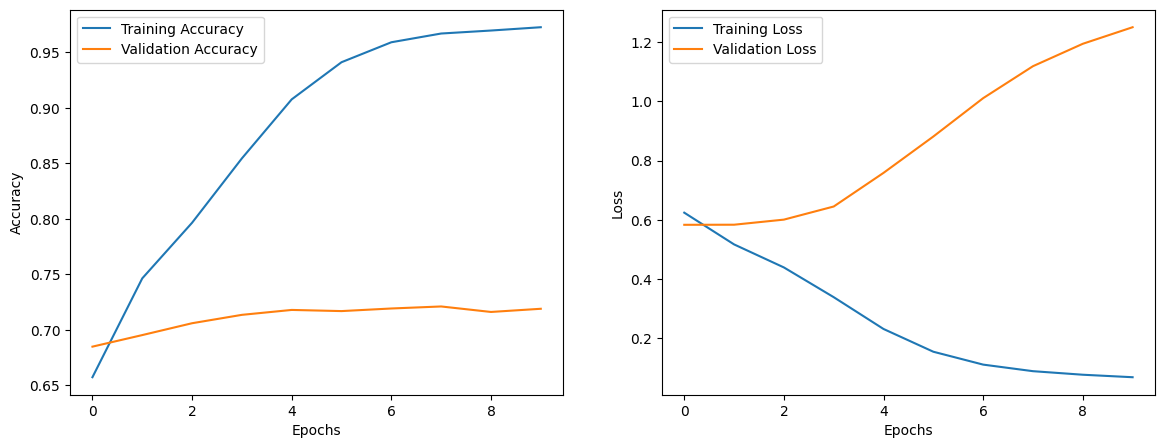

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
x_test[0]

'تاخر سعوديه شو دفع قطر عصاب مليار 😉'

In [ ]:
y_pred =model.predict(X_test_tfidf)

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
def myfunc(x):
  if x >= 0.5:
    return 1
  else:
    return 0
y_pred =np.array([myfunc(x) for x in y_pred])

In [ ]:
cm = confusion_matrix(y_test_encoded,y_pred)


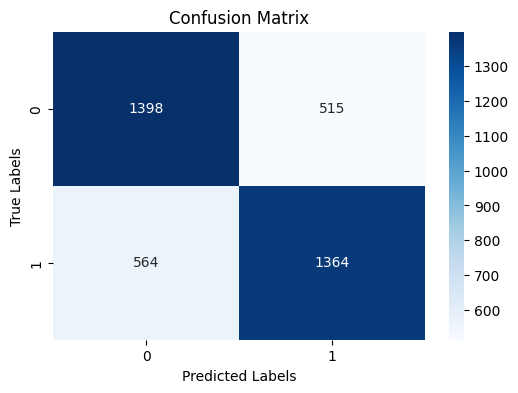

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
x =['❤️ يسعد دينك ي ذلمه شو هالاحتراف']

In [ ]:
def predict_sentiment(text):
  test_sample =vectorizer.transform(text).toarray()
  result =model.predict(test_sample)
  y = "pos" if myfunc(result) > 0.5 else "neg"
  print(f"predicted Label of x is {y}")


In [ ]:
predict_sentiment(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
predicted Label of x is pos
